In [565]:
import numpy as np 
import os 
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from matplotlib import colors 
from matplotlib.ticker import PercentFormatter 
from mpl_toolkits.mplot3d import Axes3D 


def triangular_plot(chains,save='None',fig_size=25):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(fig_size,fig_size))
    fig.set(facecolor = "white")
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i+1}")
    for i in range(ndim):
        for j in range(i):
            plt.subplot(ndim,ndim,ndim*i+j+1)
            counts,xbins,ybins,image = plt.hist2d(data[:,j],data[:,i],bins=100
                                      ,norm=LogNorm()
                                      , cmap = plt.cm.rainbow)
            plt.colorbar()
            plt.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
            linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
    if save != 'None':
        plt.savefig(save,transparent=False)
        plt.show()
    else: 
        plt.show()

def triangular_plot_slopes(chains,save='None',fig_size=25):
    data=chains.numpy()
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(fig_size,fig_size))
    fig.set(facecolor = "white")
    for i in range(ndim):
        for j in range(i):
            ax=fig.add_subplot(ndim,ndim,ndim*i+j+1)
            #those_slope0=np.extract(np.abs(data[:,0])>0.2,data[:,i]/data[:,j])
            those_slope0=data[:,i]/data[:,j]
            those_slope=np.extract(np.abs(those_slope0)<10,those_slope0)
            ax.hist(those_slope,bins=100)
            ax.set_title(f"x{j+1}/x{i+1}")
            #ax.set_ylabel(f"x{i}")
    if save != 'None':
        plt.savefig(save,transparent=False)
        plt.show()
    else: 
        plt.show()

In [9]:
import tensorflow as tf
import time

In [281]:
%matplotlib widget

In [10]:
# compute (||∇V||^2)
def grad_norm_squared(V, x ,factor=1):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)  # compute V at each point
    gradients = tape.gradient(loss, x)  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared * factor

def get_grad(V, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)  # compute V at each point
    gradients = tape.gradient(loss, x)  # compute ∇V at each point
    return gradients

In [377]:
def VHiggs_3d(x):
    x1,x2,x3=tf.split(x, 3, axis=1)
    return x1**2*(x1**2+x2**2-1)**2
def VHiggs_3d_scrambled(x):
    x1_temp,x2_temp,x3_temp=tf.split(x, 3, axis=1)
    x1 = x1_temp+x2_temp+x3_temp
    x2 = x2_temp+x3_temp
    x3 = x1_temp-x2_temp+x3_temp
    return x1**2*(x1**2+x2**2-1)**2    

In [378]:
# randomly initialize the points
n_points = 100000
xHiggs_3d = tf.Variable(4*np.random.rand(n_points, 3)-2, dtype=tf.float32)

historyHiggs_3d = []

In [382]:
# Oprimizer for the gradient descent

init_alpha=10**(-3)
alpha = init_alpha

optimizer = tf.optimizers.Adam(learning_rate=alpha)
#optimizer = tf.optimizers.SGD(learning_rate=init_alpha,momentum=0.0)

# Learning loop 
loss_prev_step=10**8

#update_alpha = False
update_opt = False
for step in range(500):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(VHiggs_3d, xHiggs_3d)) # minimize ||∇V||^2 for all points
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [xHiggs_3d])

    #if update_alpha and step % 300 == 0 and step != 0:
    #    alpha = alpha/2
    #    optimizer = tf.optimizers.Adam(learning_rate=alpha)
    if update_opt and step % 200 ==0 :
        print("Reinitializing the optimizer")
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    
    if step == 2001:
        update_opt = False 
        optimizer.learning_rate.assign(0.001)
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [xHiggs_3d]))
    
    historyHiggs_3d.append(loss)
    
    if step % 10 == 0:
        print(f"""Step {step}: ||∇V||^2 = {loss.numpy()} with learning rate {optimizer.get_config()["learning_rate"]}""")
        
    if np.log(loss.numpy())/np.log(10)<-10: 
        print("Converged enough") 
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

Step 0: ||∇V||^2 = 0.00010413087147753686 with learning rate 0.0010000000474974513
Step 10: ||∇V||^2 = 0.027393896132707596 with learning rate 0.0010000000474974513
Step 20: ||∇V||^2 = 0.0110816340893507 with learning rate 0.0010000000474974513
Step 30: ||∇V||^2 = 0.0037255939096212387 with learning rate 0.0010000000474974513
Step 40: ||∇V||^2 = 0.0011456552892923355 with learning rate 0.0010000000474974513
Step 50: ||∇V||^2 = 0.0005248033558018506 with learning rate 0.0010000000474974513
Step 60: ||∇V||^2 = 0.00018701321096159518 with learning rate 0.0010000000474974513
Step 70: ||∇V||^2 = 5.347827391233295e-05 with learning rate 0.0010000000474974513
Step 80: ||∇V||^2 = 2.835244231391698e-05 with learning rate 0.0010000000474974513
Step 90: ||∇V||^2 = 9.486012459092308e-06 with learning rate 0.0010000000474974513
Step 100: ||∇V||^2 = 3.239443913116702e-06 with learning rate 0.0010000000474974513
Step 110: ||∇V||^2 = 1.2720424820145126e-06 with learning rate 0.0010000000474974513
Step

KeyboardInterrupt: 

In [383]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(VHiggs_3d,xHiggs_3d)**2,axis=1).numpy()>10**(-i))}")
          

Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 0
Number of points with ||∇V||^2 > 1e-05 : 0
Number of points with ||∇V||^2 > 1e-06 : 0
Number of points with ||∇V||^2 > 1e-07 : 0
Number of points with ||∇V||^2 > 1e-08 : 0
Number of points with ||∇V||^2 > 1e-09 : 0
Number of points with ||∇V||^2 > 1e-10 : 48
Number of points with ||∇V||^2 > 1e-11 : 279
Number of points with ||∇V||^2 > 1e-12 : 780
Number of points with ||∇V||^2 > 1e-13 : 3310
Number of points with ||∇V||^2 > 1e-14 : 6955


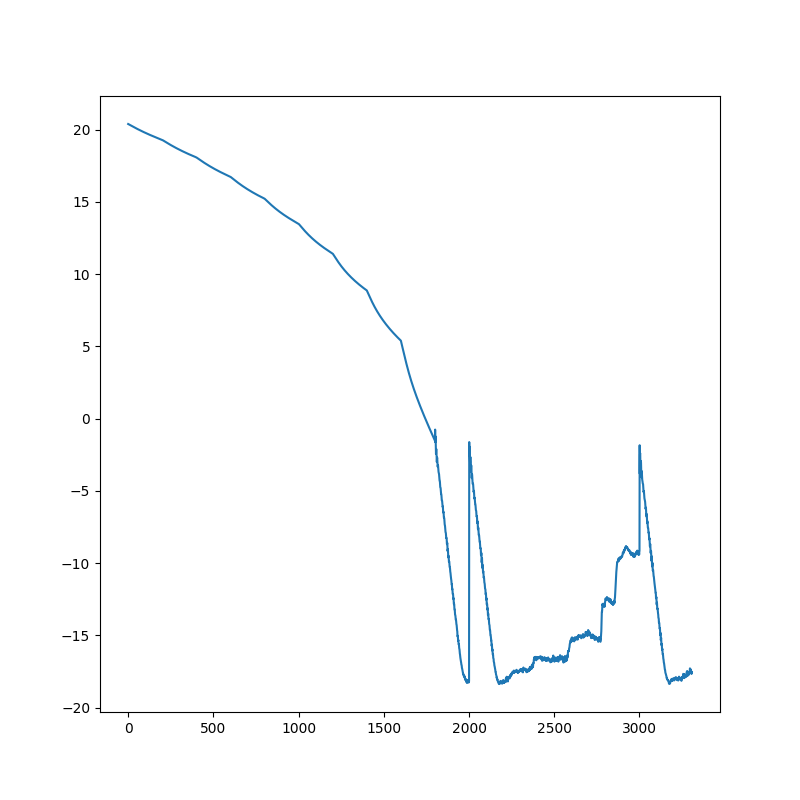

In [384]:
#all_steps = np.linspace(1,len(history),len(history))
plt.figure(figsize=(8,8))
plt.plot(np.log(historyHiggs_3d))
plt.show()

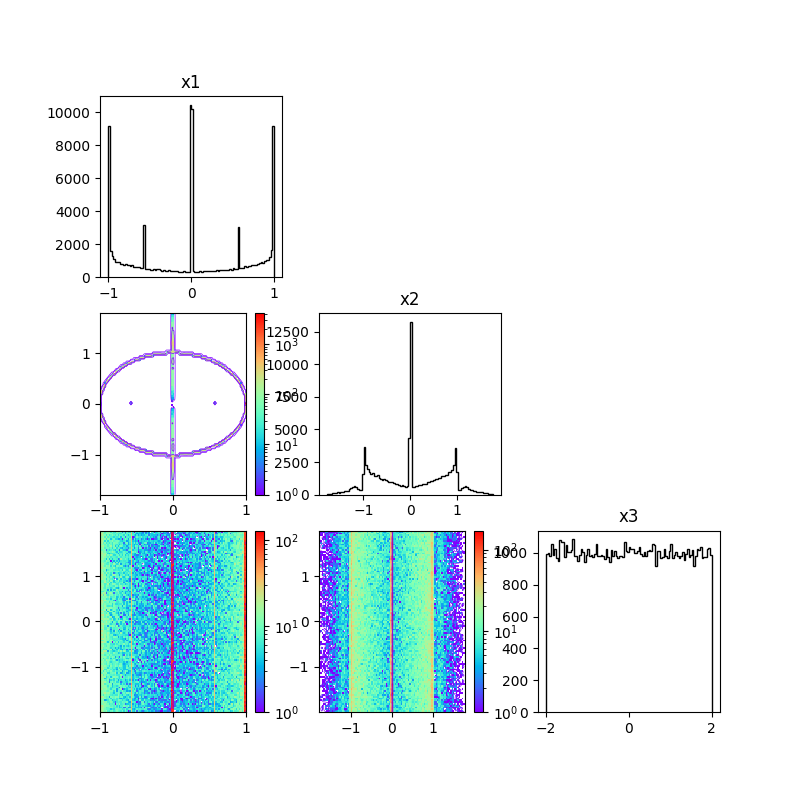

In [386]:
triangular_plot(xHiggs_3d.numpy(),fig_size=8)

/var/folders/7f/2871v4nx3pn_dph55xj6sxq40000gn/T/ipykernel_9513/21697265.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


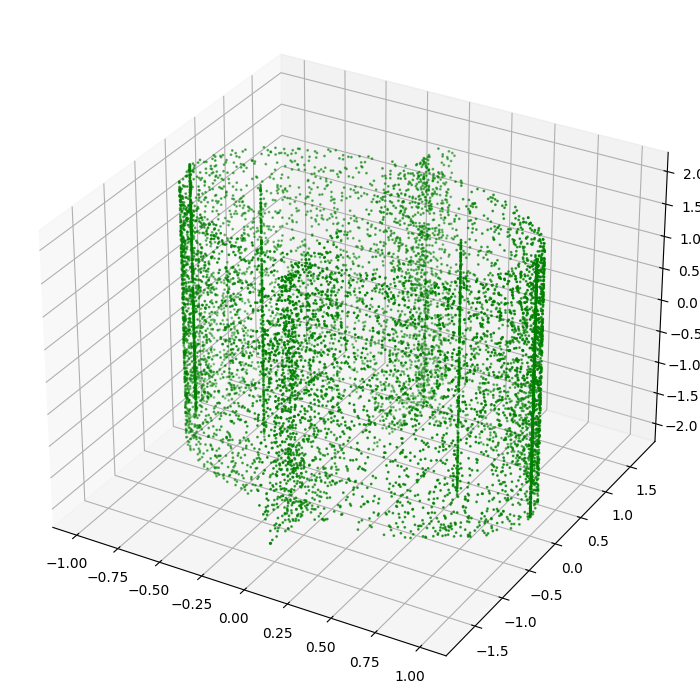

In [407]:
fig = plt.figure(figsize=(7,7))
ax = Axes3D(fig) 

ax.scatter(xHiggs_3d.numpy()[::10,0], xHiggs_3d.numpy()[::10,1], xHiggs_3d.numpy()[::10,2],color="green",s=1) 

plt.show()


In [1]:
################ Auto encoder part ################
###################################################
###################################################

In [388]:
import keras
from keras import layers

In [442]:
#

input_dim = 3  
latent_dim = 3 

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(8, activation='sigmoid')(inputs)
#encoded = layers.Dense(16, activation='sigmoid')(encoded)
#encoded = layers.Dense(16, activation='sigmoid')(encoded)
#encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
#decoded = layers.Dense(16, activation='sigmoid')(decoded)
#decoded = layers.Dense(16, activation='sigmoid')(decoded)
#decoded = layers.Dense(8, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Modèle auto-encodeur
autoencoder_deep = keras.Model(inputs, decoded)
autoencoder_deep.compile(optimizer='adam', loss='mse')

In [443]:
autoencoder_deep.summary()

Model: "functional_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_58 (InputLayer)     │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_534 (Dense)               │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_535 (Dense)               │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_536 (Dense)               │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_537 (Dense)               │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118 (472.00 B)

 Trainable params: 118 (472.00 B)

 Non-trainable params: 0 (0.00 B)

In [444]:
mask_train = np.array([np.random.rand()<0.9 for i in range(100000)])
set_train = np.array([np.extract(mask_train,xHiggs_3d.numpy()[:,i]) for i in range(3)]).T
set_test = np.array([np.extract(1-mask_train,xHiggs_3d.numpy()[:,i]) for i in range(3)]).T
print(set_train.shape)
print(set_test.shape)

(89924, 3)
(10076, 3)


In [445]:
history_autoencoder_Higgs = autoencoder_deep.fit(set_train, set_train, epochs=100, batch_size=100, shuffle=True, validation_data=(set_test,set_test))


Epoch 1/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6096 - val_loss: 0.0597
Epoch 2/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0232 - val_loss: 0.0076
Epoch 3/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0067 - val_loss: 0.0048
Epoch 4/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 5/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 6/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 7/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0012 - val_loss: 9.8772e-04
Epoch 9/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.0641e-04 - val_loss: 7.9819e-04
Epoch 10/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.3241e-04 - val_loss: 6.3450e-04
Epoch 11/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.1234e-04 - val_loss: 5.5375e-04
Epoch 12/100


900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.7520e-05 - val_loss: 8.3961e-05
Epoch 65/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.4207e-05 - val_loss: 9.6687e-05
Epoch 66/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.2048e-05 - val_loss: 7.5529e-05
Epoch 67/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.0156e-05 - val_loss: 9.6201e-05
Epoch 68/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.4184e-05 - val_loss: 7.4327e-05
Epoch 69/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.2671e-05 - val_loss: 8.2300e-05
Epoch 70/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.0121e-05 - val_loss: 8.0033e-05
Epoch 71/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.7534e-05 - val_loss: 9.2566e-05
Epoch 72/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.7634e-05 - val_loss: 9.0685e-05
Epoch 73/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.5881e-05 - val_loss: 8.3339e-05
Epoch 74/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

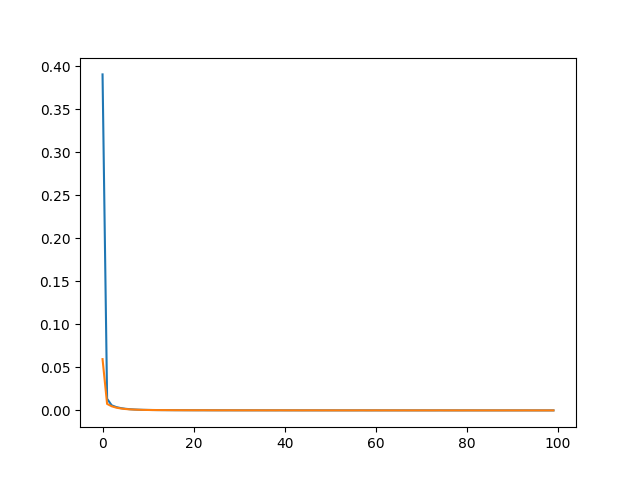

In [446]:
plt.figure()
plt.plot(history_autoencoder_Higgs.history["loss"])
plt.plot(history_autoencoder_Higgs.history["val_loss"])
plt.show()

In [447]:
encoder_Higgs = keras.Model(inputs, encoded)

In [448]:
encoded_points_Higgs = encoder_Higgs.predict(set_test)  
reconstructed_points_deep = autoencoder_deep.predict(set_test)  


315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


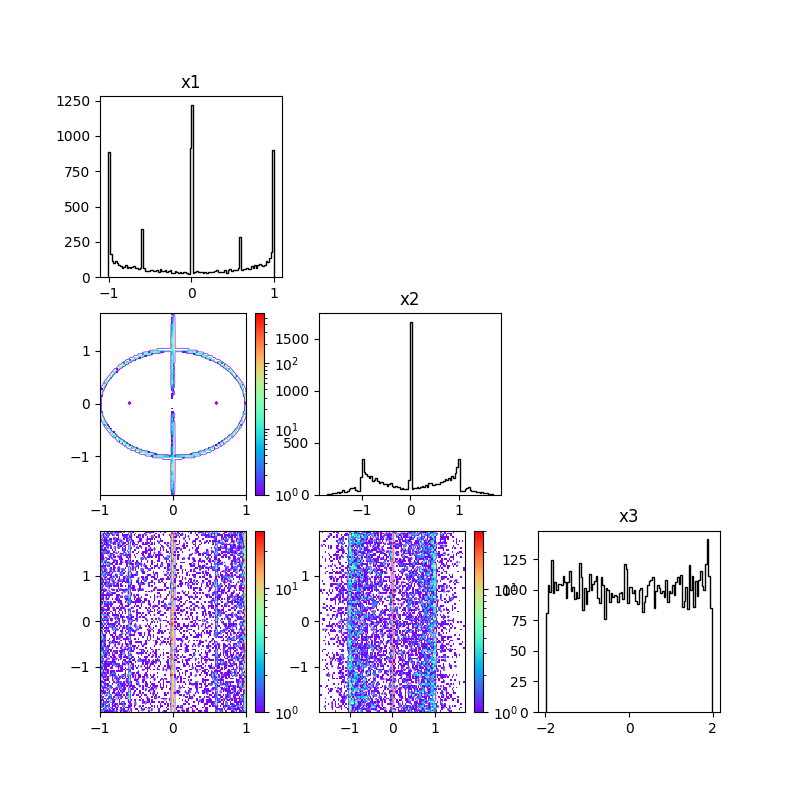

In [449]:
triangular_plot(reconstructed_points_deep,fig_size = 8)

/var/folders/7f/2871v4nx3pn_dph55xj6sxq40000gn/T/ipykernel_9513/309963268.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


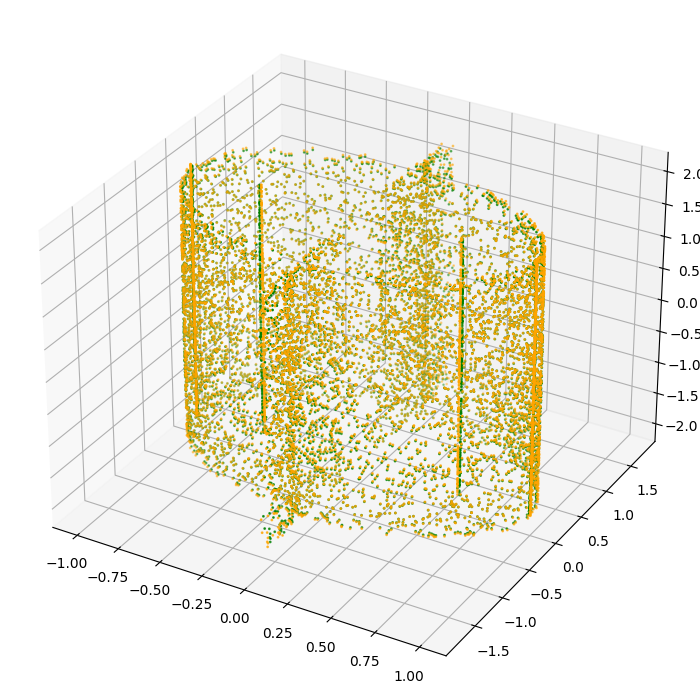

In [450]:
fig = plt.figure(figsize=(7,7))
ax = Axes3D(fig) 

ax.scatter(reconstructed_points_deep[:,0],reconstructed_points_deep[:,1],reconstructed_points_deep[:,2],color="green",s=1) 
ax.scatter(set_test[:,0],set_test[:,1],set_test[:,2],color="orange",s=1) 

plt.show()


In [ ]:
###### Scrambled potential 

In [61]:
# randomly initialize the points
n_points = 100000
xHiggs_3d_scrambled = tf.Variable(4*np.random.rand(n_points, 3)-2, dtype=tf.float32)

historyHiggs_3d_scrambled = []

In [83]:
# Oprimizer for the gradient descent

init_alpha=10**(-3)
alpha = init_alpha

optimizer = tf.optimizers.Adam(learning_rate=alpha)
#optimizer = tf.optimizers.SGD(learning_rate=init_alpha,momentum=0.0)

# Learning loop 
loss_prev_step=10**8

#update_alpha = False
update_opt = False
for step in range(500):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(VHiggs_3d_scrambled, xHiggs_3d_scrambled)) # minimize ||∇V||^2 for all points
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [xHiggs_3d_scrambled])

    #if update_alpha and step % 300 == 0 and step != 0:
    #    alpha = alpha/2
    #    optimizer = tf.optimizers.Adam(learning_rate=alpha)
    if update_opt and step % 200 ==0 :
        print("Reinitializing the optimizer")
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    
    if step == 601:
        update_opt = False 
        #optimizer.learning_rate.assign(0.01)
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [xHiggs_3d_scrambled]))
    
    historyHiggs_3d_scrambled.append(loss)
    
    if step % 10 == 0:
        print(f"""Step {step}: ||∇V||^2 = {loss.numpy()} with learning rate {optimizer.get_config()["learning_rate"]}""")
        
    if np.log(loss.numpy())/np.log(10)<-10: 
        print("Converged enough") 
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

Step 0: ||∇V||^2 = 9.971986582968384e-05 with learning rate 0.0010000000474974513
Step 10: ||∇V||^2 = 4401.94580078125 with learning rate 0.0010000000474974513
Step 20: ||∇V||^2 = 793.26611328125 with learning rate 0.0010000000474974513
Step 30: ||∇V||^2 = 4.018472194671631 with learning rate 0.0010000000474974513
Step 40: ||∇V||^2 = 82.31130981445312 with learning rate 0.0010000000474974513
Step 50: ||∇V||^2 = 52.14886474609375 with learning rate 0.0010000000474974513
Step 60: ||∇V||^2 = 18.64539337158203 with learning rate 0.0010000000474974513
Step 70: ||∇V||^2 = 3.779299259185791 with learning rate 0.0010000000474974513
Step 80: ||∇V||^2 = 0.05271302908658981 with learning rate 0.0010000000474974513
Step 90: ||∇V||^2 = 0.547431230545044 with learning rate 0.0010000000474974513
Step 100: ||∇V||^2 = 0.4892576336860657 with learning rate 0.0010000000474974513
Step 110: ||∇V||^2 = 0.013464169576764107 with learning rate 0.0010000000474974513
Step 120: ||∇V||^2 = 0.05242658406496048 wit

In [84]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(VHiggs_3d_scrambled,xHiggs_3d_scrambled)**2,axis=1).numpy()>10**(-i))}")
          

Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 0
Number of points with ||∇V||^2 > 1e-05 : 0
Number of points with ||∇V||^2 > 1e-06 : 0
Number of points with ||∇V||^2 > 1e-07 : 46
Number of points with ||∇V||^2 > 1e-08 : 143
Number of points with ||∇V||^2 > 1e-09 : 624
Number of points with ||∇V||^2 > 1e-10 : 1741
Number of points with ||∇V||^2 > 1e-11 : 3354
Number of points with ||∇V||^2 > 1e-12 : 4755
Number of points with ||∇V||^2 > 1e-13 : 5915
Number of points with ||∇V||^2 > 1e-14 : 6811


In [92]:
mask_m15

array([ True,  True,  True, ...,  True,  True,  True])

In [100]:
mask_m15 = tf.reduce_sum(get_grad(VHiggs_3d_scrambled,xHiggs_3d_scrambled)**2,axis=1).numpy()<10**(-15)
xHiggs_3d_sc_sorted = np.array([np.extract(mask_m15,xHiggs_3d_scrambled.numpy()[:,i]) for i in range(3)]).T

In [101]:
xHiggs_3d_sc_sorted.shape

(92375, 3)

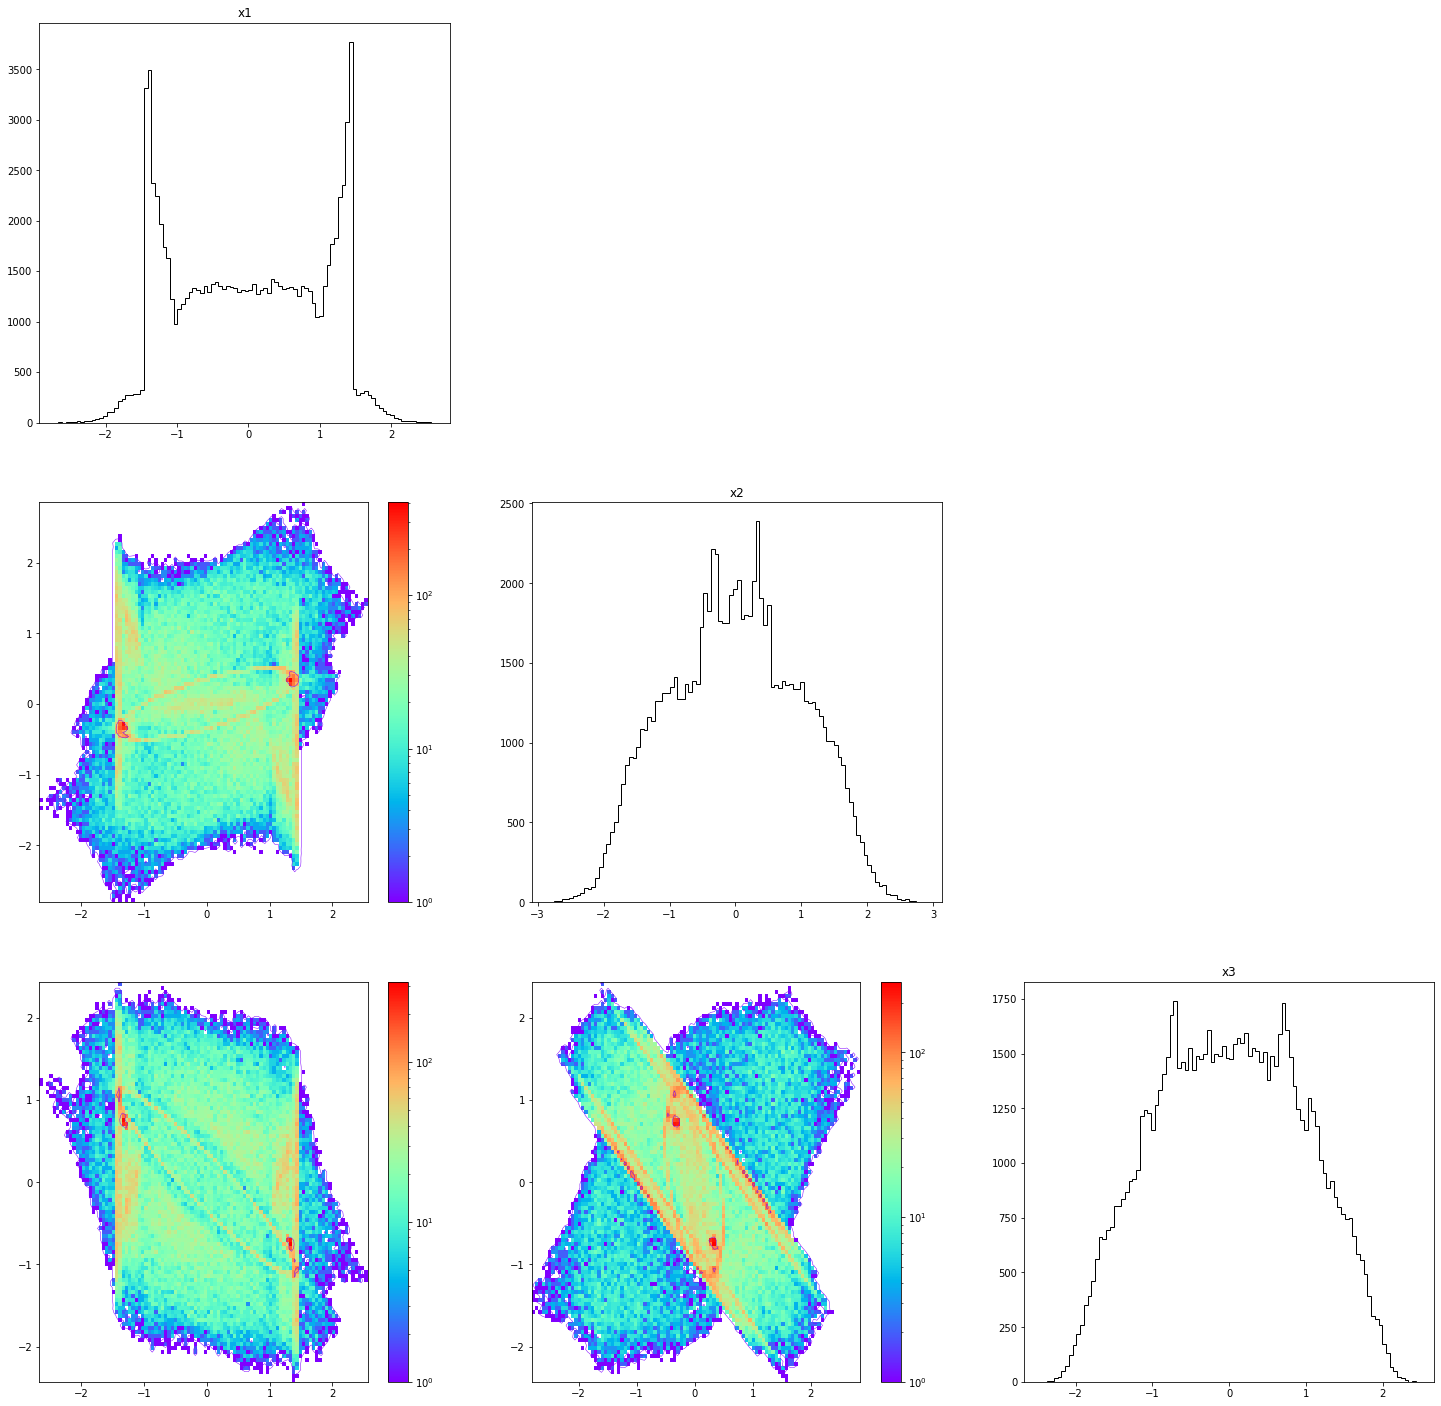

In [102]:
triangular_plot(xHiggs_3d_sc_sorted)

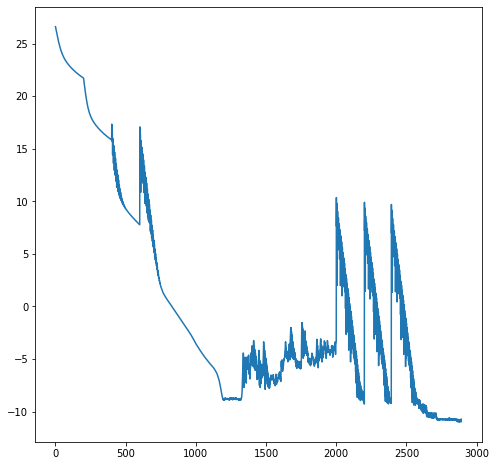

In [103]:
#all_steps = np.linspace(1,len(history),len(history))
plt.figure(figsize=(8,8))
plt.plot(np.log(historyHiggs_3d_scrambled))
plt.show()

In [500]:
# Create the autoencoder 
input_dim = 3 
latent_dim = 3

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(8, activation='sigmoid')(inputs)
#encoded = layers.Dense(8, activation='sigmoid')(encoded)
#encoded = layers.Dense(16, activation='relu')(encoded)
#encoded = layers.Dense(8, activation='relu')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
#decoded = layers.Dense(8, activation='sigmoid')(decoded)
#decoded = layers.Dense(16, activation='relu')(decoded)
#decoded = layers.Dense(8, activation='relu')(decoded)
decoded = layers.Dense(input_dim)(decoded) 

# Modèle auto-encodeur
autoencoder_deep_scrambled = keras.Model(inputs, decoded)
autoencoder_deep_scrambled.compile(optimizer='adam', loss='mse')

In [501]:
autoencoder_deep_scrambled.summary()

Model: "functional_167"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_66 (InputLayer)     │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_572 (Dense)               │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_573 (Dense)               │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_574 (Dense)               │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_575 (Dense)               │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118 (472.00 B)

 Trainable params: 118 (472.00 B)

 Non-trainable params: 0 (0.00 B)

In [502]:
history_autoencoder_Higgs_scrambled = autoencoder_deep_scrambled.fit(xHiggs_3d_sc_sorted, xHiggs_3d_sc_sorted, epochs=500, batch_size=100, shuffle=True)


Epoch 1/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.8816
Epoch 2/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2309
Epoch 3/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0267
Epoch 4/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0124
Epoch 5/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073
Epoch 6/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0046
Epoch 7/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0032
Epoch 8/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024
Epoch 9/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0019
Epoch 10/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0015
Epoch 11/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012
Epoch 12/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0011
Epoch 13/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.3729e-04
Epoch 14/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.3851e-04
Epoch 15/500
924/924 ━━━━━━━━━━━━━━

924/924 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.5586e-04
Epoch 79/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.4712e-04
Epoch 80/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.4779e-04
Epoch 81/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.4625e-04
Epoch 82/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.4571e-04
Epoch 83/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.4397e-04
Epoch 84/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.4207e-04
Epoch 85/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.4363e-04
Epoch 86/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.3935e-04
Epoch 87/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.4195e-04
Epoch 88/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.4071e-04
Epoch 89/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.4032e-04
Epoch 90/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.3701e-04
Epoch 91/500
924/924 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.

KeyboardInterrupt: 

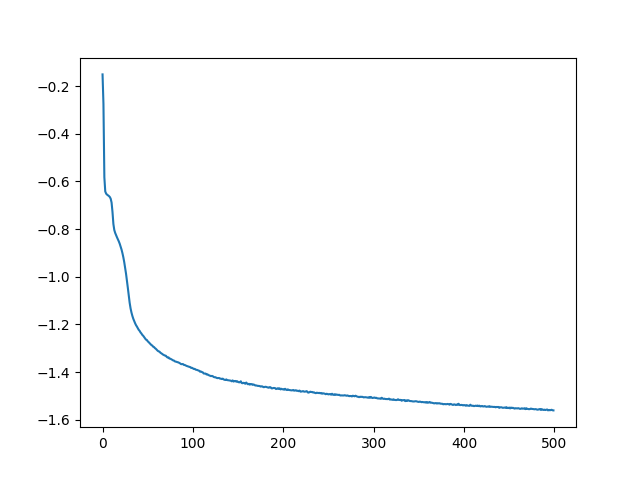

In [503]:
plt.figure()
plt.plot(np.log(history_autoencoder_Higgs_scrambled.history["loss"])/np.log(10))
plt.show()

In [504]:
reconstructed_points_deep_sc = autoencoder_deep_scrambled.predict(xHiggs_3d_sc_sorted)  


2887/2887 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


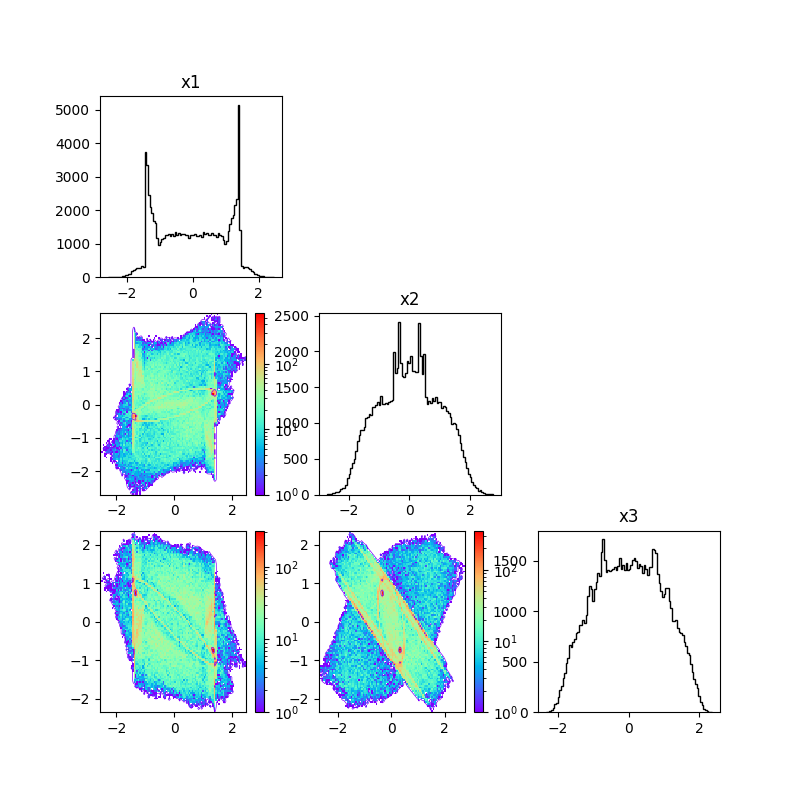

In [505]:
triangular_plot(reconstructed_points_deep_sc,fig_size=8)

/var/folders/7f/2871v4nx3pn_dph55xj6sxq40000gn/T/ipykernel_9513/565528221.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


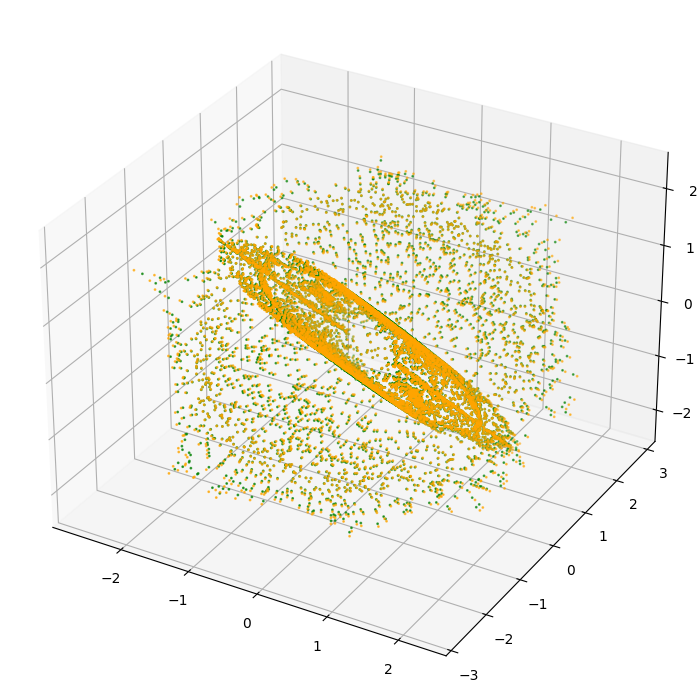

In [506]:
fig = plt.figure(figsize=(7,7))
ax = Axes3D(fig) 

ax.scatter(reconstructed_points_deep_sc[::10,0],reconstructed_points_deep_sc[::10,1],reconstructed_points_deep_sc[::10,2],color="green",s=1) 
ax.scatter(xHiggs_3d_sc_sorted[::10,0],xHiggs_3d_sc_sorted[::10,1],xHiggs_3d_sc_sorted[::10,2],color="orange",s=1) 

plt.show()


In [560]:
# So with 3 nodes in the middle, it is possible to reconstruct the points

In [559]:
# If we try to do 1 or 2 nodes in the middle, this will fail
# Try first to extract 1d lines

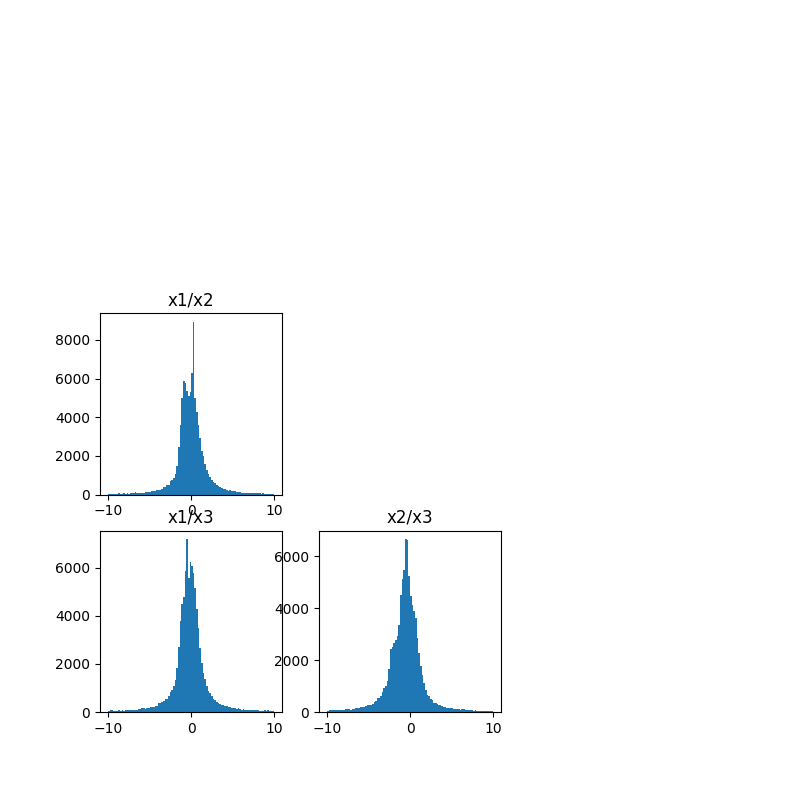

In [566]:
triangular_plot_slopes(xHiggs_3d_scrambled,fig_size=8)

In [575]:
those_slope0=xHiggs_3d_scrambled[:,1]/xHiggs_3d_scrambled[:,0]
those_slope=np.extract(np.abs(those_slope0)<10,those_slope0)
this_hist=plt.hist(those_slope,bins=100)

In [576]:
this_hist[1][np.argmax(this_hist[0])]

0.20426743

In [581]:
mask_train = np.array([np.random.rand()<0.9 for i in range(100000)])
set_train = np.array([np.extract(mask_train,xHiggs_3d_scrambled.numpy()[:,i]) for i in range(3)]).T
set_test = np.array([np.extract(1-mask_train,xHiggs_3d_scrambled.numpy()[:,i]) for i in range(3)]).T
print(set_train.shape)
print(set_test.shape)

(90210, 3)
(9790, 3)


In [644]:
# Create the autoencoder 
input_dim = 3 
latent_dim = 2

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation='relu')(inputs)
encoded = layers.Dense(128, activation='relu')(encoded)
encoded = layers.Dense(128, activation='relu')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(128, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(input_dim)(decoded) 

# Modèle auto-encodeur
autoencoder_deep_scrambled_2node = keras.Model(inputs, decoded)
autoencoder_deep_scrambled_2node.compile(optimizer='adam', loss='mse')

# Fairly large. Smaller also seem to work, but not as good. Should play more with it. 

In [645]:
autoencoder_deep_scrambled_2node.summary()

Model: "functional_197"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_81 (InputLayer)     │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_660 (Dense)               │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_661 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_662 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_663 (Dense)               │ (None, 2)              │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_664 (Dense)               │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_665 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_666 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_667 (Dense)               │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,589 (264.02 KB)

 Trainable params: 67,589 (264.02 KB)

 Non-trainable params: 0 (0.00 B)

In [646]:
history_autoencoder_Higgs_scrambled_2node = autoencoder_deep_scrambled_2node.fit(set_train, set_train
                                    , epochs=500
                                    , batch_size=100
                                    , shuffle=True
                                    , validation_data = (set_test,set_test))


Epoch 1/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1759 - val_loss: 0.0452
Epoch 2/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0413 - val_loss: 0.0339
Epoch 3/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0308 - val_loss: 0.0250
Epoch 4/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0257 - val_loss: 0.0344
Epoch 5/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0287 - val_loss: 0.0243
Epoch 6/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0212 - val_loss: 0.0202
Epoch 7/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0185 - val_loss: 0.0230
Epoch 8/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0295 - val_loss: 0.0202
Epoch 9/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0181 - val_loss: 0.0255
Epoch 10/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0176 - val_loss: 0.0246
Epoch 11/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0211 - val_loss: 0.0172
Epoch 12/500
903/903 ━━━━━━━━━━━━━━━━━━━━

903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0118 - val_loss: 0.0086
Epoch 69/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0105 - val_loss: 0.0132
Epoch 70/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0129 - val_loss: 0.0113
Epoch 71/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0127 - val_loss: 0.0104
Epoch 72/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0100 - val_loss: 0.0148
Epoch 73/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0140 - val_loss: 0.0137
Epoch 74/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0114 - val_loss: 0.0194
Epoch 75/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0142 - val_loss: 0.0151
Epoch 76/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0104 - val_loss: 0.0111
Epoch 77/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0123 - val_loss: 0.0152
Epoch 78/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0131 - val_loss: 0.0108
Epoch 79/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 

Epoch 135/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 136/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 137/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0066 - val_loss: 0.0050
Epoch 138/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0061 - val_loss: 0.0228
Epoch 139/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0115 - val_loss: 0.0056
Epoch 140/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 141/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 142/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0055 - val_loss: 0.0097
Epoch 143/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 144/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0075 - val_loss: 0.0049
Epoch 145/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 146/500
903/903

903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0081 - val_loss: 0.0072
Epoch 202/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0114 - val_loss: 0.0072
Epoch 203/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085 - val_loss: 0.0102
Epoch 204/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0086 - val_loss: 0.0075
Epoch 205/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0122 - val_loss: 0.0099
Epoch 206/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0113 - val_loss: 0.0069
Epoch 207/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080 - val_loss: 0.0390
Epoch 208/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0252 - val_loss: 0.0111
Epoch 209/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0121 - val_loss: 0.0111
Epoch 210/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0128 - val_loss: 0.0320
Epoch 211/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0144 - val_loss: 0.0110
Epoch 212/500
903/903 ━━━━━━━━━━━━━

903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0107 - val_loss: 0.0102
Epoch 268/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 269/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0113 - val_loss: 0.0136
Epoch 270/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0159 - val_loss: 0.0095
Epoch 271/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0114 - val_loss: 0.0098
Epoch 272/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0126 - val_loss: 0.0082
Epoch 273/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0099 - val_loss: 0.0076
Epoch 274/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084 - val_loss: 0.0079
Epoch 275/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080 - val_loss: 0.0082
Epoch 276/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 277/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0090 - val_loss: 0.0306
Epoch 278/500
903/903 ━━━━━━━━━━━━━

903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085 - val_loss: 0.0088
Epoch 334/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082 - val_loss: 0.0071
Epoch 335/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0080 - val_loss: 0.0065
Epoch 336/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0075 - val_loss: 0.0099
Epoch 337/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0122 - val_loss: 0.0309
Epoch 338/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0459 - val_loss: 0.0232
Epoch 339/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0223 - val_loss: 0.0251
Epoch 340/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0213 - val_loss: 0.0128
Epoch 341/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0131 - val_loss: 0.0092
Epoch 342/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0096 - val_loss: 0.0085
Epoch 343/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0083 - val_loss: 0.0089
Epoch 344/500
903/903 ━━━━━━━━━━━━━

903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0065 - val_loss: 0.0109
Epoch 400/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0074 - val_loss: 0.0063
Epoch 401/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0067 - val_loss: 0.0185
Epoch 402/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0102 - val_loss: 0.0088
Epoch 403/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0081 - val_loss: 0.0061
Epoch 404/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069 - val_loss: 0.0057
Epoch 405/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0063 - val_loss: 0.0102
Epoch 406/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0153 - val_loss: 0.0127
Epoch 407/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0106 - val_loss: 0.0087
Epoch 408/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0083 - val_loss: 0.0092
Epoch 409/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0109 - val_loss: 0.0086
Epoch 410/500
903/903 ━━━━━━━━━━━━━

903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0092 - val_loss: 0.0064
Epoch 466/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085 - val_loss: 0.0096
Epoch 467/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0091 - val_loss: 0.0070
Epoch 468/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0079 - val_loss: 0.0072
Epoch 469/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0072 - val_loss: 0.0075
Epoch 470/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0087 - val_loss: 0.0111
Epoch 471/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0086 - val_loss: 0.0250
Epoch 472/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0159 - val_loss: 0.0133
Epoch 473/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0104 - val_loss: 0.0204
Epoch 474/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0102 - val_loss: 0.0070
Epoch 475/500
903/903 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0066 - val_loss: 0.0070
Epoch 476/500
903/903 ━━━━━━━━━━━━━

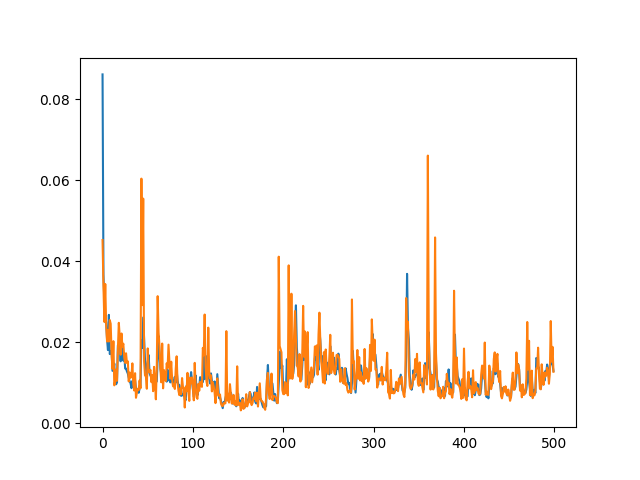

In [647]:
plt.figure()
plt.plot(history_autoencoder_Higgs_scrambled_2node.history["loss"])
plt.plot(history_autoencoder_Higgs_scrambled_2node.history["val_loss"])
plt.show()

In [648]:
reconstructed_points_deep_sc_2node = autoencoder_deep_scrambled_2node.predict(xHiggs_3d_scrambled.numpy())  


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


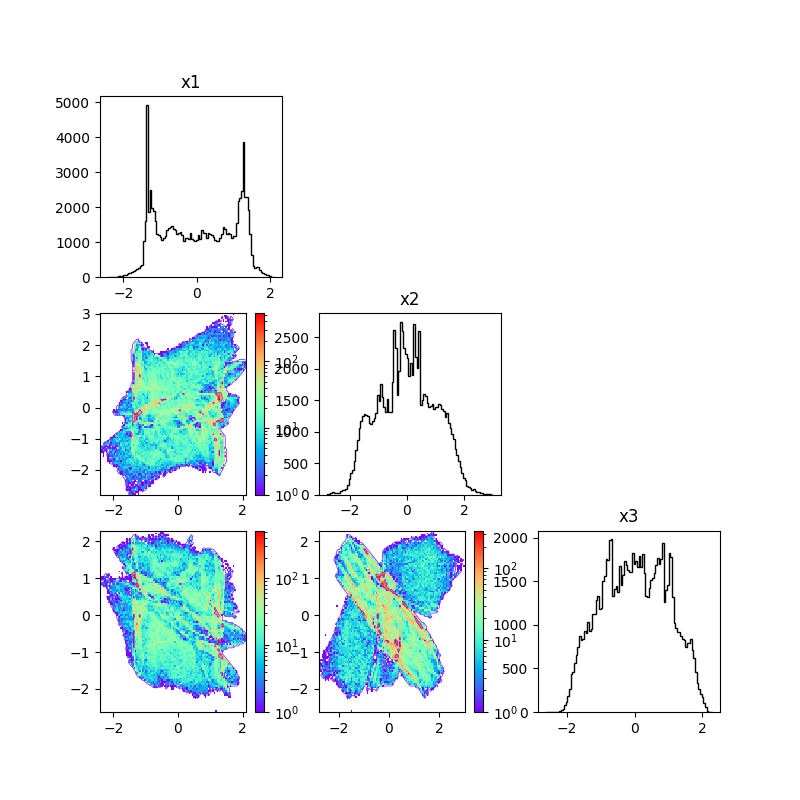

In [649]:
triangular_plot(reconstructed_points_deep_sc_2node,fig_size=8)

/var/folders/7f/2871v4nx3pn_dph55xj6sxq40000gn/T/ipykernel_9513/2795477961.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


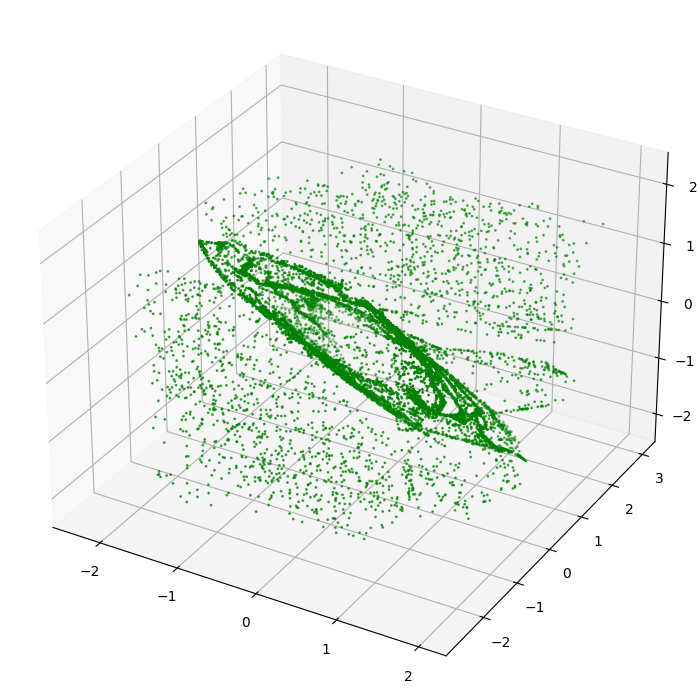

In [650]:
fig = plt.figure(figsize=(7,7))
ax = Axes3D(fig) 

ax.scatter(reconstructed_points_deep_sc_2node[::10,0],reconstructed_points_deep_sc_2node[::10,1],reconstructed_points_deep_sc_2node[::10,2],color="green",s=1) 
#ax.scatter(xHiggs_3d_sc_sorted[::10,0],xHiggs_3d_sc_sorted[::10,1],xHiggs_3d_sc_sorted[::10,2],color="orange",s=1) 

plt.show()


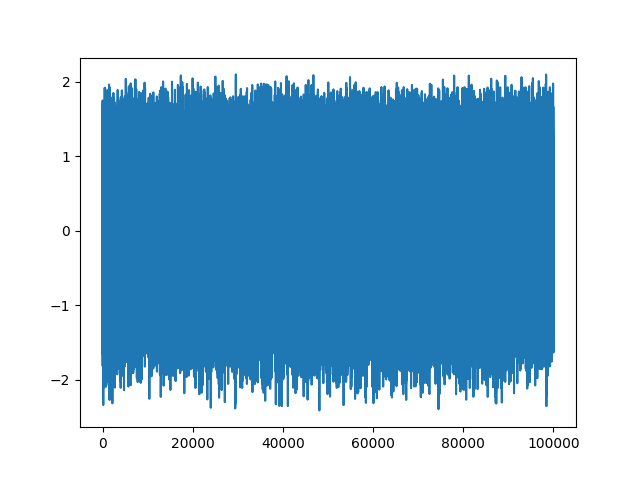

In [651]:
plt.figure()
plt.plot(reconstructed_points_deep_sc_2node[:,0])
plt.show()